<a href="https://colab.research.google.com/github/neelkanthrawat/GNN-exercises/blob/main/Assignment_1_Neel's_attempt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
from typing import List
from numpy.linalg import norm
from IPython.core.formatters import Dict
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import numpy as np
from matplotlib.patches import Ellipse

In [2]:
# Generate the dataset
# X, _ = make_moons(n_samples=100, noise=0.05, random_state=0)
# plt.figure(figsize=(8, 6))
# plt.scatter(X[:, 0], X[:, 1], c='blue', label='make_moons dataset', alpha=0.5)
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend()
# plt.title('make_moons Dataset')
# plt.show()

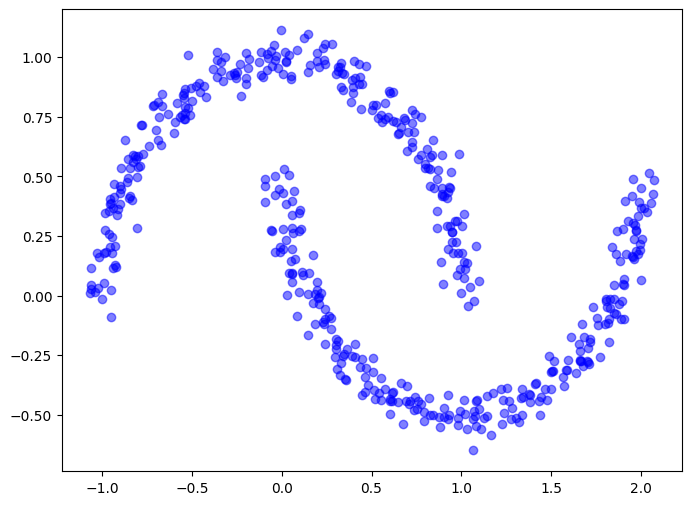

In [4]:
# Generate the 2D dataset using sklearn
# Create the moon datasets of varying sizes
n_samples_small = 100
n_samples_medium = 500
n_samples_large = 1000

datasets = {
    "Small": make_moons(n_samples=n_samples_small, noise=0.05, random_state=0),
    "Medium": make_moons(n_samples=n_samples_medium, noise=0.05, random_state=0),
    "Large": make_moons(n_samples=n_samples_large, noise=0.05, random_state=0),
}

#let's plot the dataset["medium"]
# X, _ = make_moons(n_samples=500, noise=0.05, random_state=0)
X,_=datasets["Medium"]
# Plot the data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='blue', label='make_moons dataset', alpha=0.5)

# 1.b. Single Gaussian Distribution model

In [3]:
### define n- dimensional gaussian distribution

### this gaussian has the ability to infer (evaluate the probability at the given point)
def gaussian_multivar(x:np.array,mean:np.array,cov_mat:np.array):
  '''
  This model will evaluate the probabilty at the given x_vector using the GMM model.
  Args:
  1. x= np array of shape (1 X dimn_of_the_problem)
  2. mean= np array of shape (1 X dimn_of_the_problem)
  3.cov_mat= square np array of shape (dimn_of_the_prob)
  '''
  dimn=np.shape(x)[0]
  inv_cov=np.linalg.inv(cov_mat)
  x_minus_mu=x-mean
  # argument for the exp
  arg_for_expn=0.5*(x_minus_mu @ inv_cov @ np.transpose(x_minus_mu))[0,0]
  det_cov=np.linalg.det(cov_mat)
  # evaluating the prob
  prob=np.exp(-arg_for_expn) * (1./(np.sqrt(det_cov*((2*np.pi)**dimn))))

  return prob

In [4]:
x=np.array([[0.5,0.5]])
mean=np.array([[1,1]])
cov_mat=np.array([[0.3,0.22],[0.22,0.8]])
check=gaussian_multivar(x,mean,cov_mat)
print(check)

0.5925320126578024


# 2. Gaussian mixture model (GMM)

In [5]:
def gaussian_mixture_model(x_input:np.array, mixing_coeffs:np.array, mean_array:np.array, covs:Dict):
  '''
  Args:
  1. x_input: x vector at which one wants to evaluate the GMM model.
              A numpy array (row vector) of shape (1 X dimn of the problem)
  2. mean:  A numpy arrray of shape (L X dimn of the problem instance)
  3. mixing coeffs: a numpy array of shape (1 X L)
  4. covs: dict of covaraince matrices, L number of entries, one for each of the P_l(x).
  '''
  L=np.shape(mean)[0]
  dimn_of_the_prob=np.shape(x_input)[1]
  list_gmm=[mixing_coeffs[0,idx_el] * gaussian_multivar(x=x_input, mean=mean_array[idx_el,:],cov_mat=covs[idx_el])
            for idx_el in range(0,L)
            ]
  prob=sum(list_gmm)## sometimes instead of 1./num_data , literature uses the factor 1./(bandwidth X num_data)
  return prob

### EM algorithm for training the params for the GMM

In [6]:
def EM_training(mean:np.array,mixing_coeffs:np.array,covs:Dict, dataset_input:np.array,num_iters:int=500,tol:float=0.0001):
  '''
  Args:
  mean= a numpy array
        shape(mean)= (L X dimension_of_the_problem_instance (whether 1D, 2D, 3D and so on))
  mixing_coeffs=
        shape(mixing_coeffs)= (1 X L)
  covs= dict of covariance matrices.
        shape(covs)= L number of entries, one for each of the P_l(x)
  dataset_input: shape would be (num of data set X dimn_of_the_prob)
  '''
  L=np.shape(mean)[0]
  print("L is:");print(L)
  dimn_of_prob=np.shape(dataset_input)[1]
  # define gamma: responsibility
  num_data=np.shape(dataset_input)[0] ### note shape(dataset_input)=(num data X dimn_of_the_problem)
  gamma=np.zeros(shape=(num_data,L))
  prev_log_likelihood = -np.inf  # Initialize the log-likelihood to negative infinity
  ###
  for t in range(0,num_iters):

    ### evaluate the E step
    # update the gamma.
    for idx_over_data in range(0,num_data):
      prod_mixing_coeffs_and_gaussian_l=[mixing_coeffs[0,idx_el]*gaussian_multivar(x=dataset_input[idx_over_data,:].reshape((1,dimn_of_prob)),mean=mean[idx_el,:].reshape((1,dimn_of_prob)),cov_mat=covs[idx_el]) for idx_el in range(0,L)]
      Dr_for_gamma=np.sum(prod_mixing_coeffs_and_gaussian_l)
      gamma[idx_over_data,:]=[prod_mixing_coeffs_and_gaussian_l[k]/Dr_for_gamma for k in range(0,L)]

    #print("gamma obtained:");print(gamma)
    ### M-step: Re-estimating the parameters
    N_l=np.sum(gamma,axis=0)# this is the expression sum_{i=1}^{N(all dataset)} gamma_{il} in the lecture notes
    #print("N_l is:");print(N_l)# NOTE:: shape of N_l = (L,) (note that this array is 1D)

    ### 1. update means: the expresion is like a wtd sum of the vectors
    for idx_el in range(0,L):
      #print("index el is:");print(idx_el)
      temp_vec=np.array(
          [gamma[idx_over_data,idx_el]*dataset_input[idx_over_data,:]
           for idx_over_data in range(0,num_data)]
          )
      mean[idx_el,:]=(1./N_l[idx_el])*np.sum(temp_vec,axis=0)
    #print("mean matrix after update:");print(mean)

    ### 2. update the covariance matrix:
    ##### formula for updating the cov mat is:
    ##### sigma_lth=1/N_l[idx_el] * sum_{i=1}^{N(all_dataset)} * gamma_{il}*some_outer_product
    for idx_el in range(0,L):
      #print("updating cov matrix, index el is:",idx_el)
      temp_outer_prod_list=np.array(
          [gamma[idx_over_data,idx_el]*(dataset_input[idx_over_data,:]-mean[idx_el,:]).reshape((dimn_of_prob,1)) @
           (dataset_input[idx_over_data,:]-mean[idx_el,:]).reshape((1,dimn_of_prob))
          for idx_over_data in range(0,num_data)
         ]
          )
      covs[idx_el]=(1./N_l[idx_el])*sum(temp_outer_prod_list)
    #print("updated covriances");print(covs)

    ### 3. update the mixing coeffs:
    for idx_el in range(0,L):
      mixing_coeffs[0,idx_el]=N_l[idx_el]/num_data

    # Calculate the log-likelihood for the current parameters
    current_log_likelihood = 0
    for idx_over_data in range(num_data):
        log_sum = np.log(sum([mixing_coeffs[0, idx_el] * gaussian_multivar(x=dataset_input[idx_over_data, :].reshape((1, dimn_of_prob)), mean=mean[idx_el, :].reshape((1, dimn_of_prob)), cov_mat=covs[idx_el]) for idx_el in range(L)]))
        current_log_likelihood += log_sum

    # Check for convergence
    if np.abs(current_log_likelihood - prev_log_likelihood) < tol:
        break

    prev_log_likelihood = current_log_likelihood

  return mean,covs,mixing_coeffs

L is:
4


<ipython-input-6-bbd0c3f2d625>:27: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  gamma[idx_over_data,:]=[prod_mixing_coeffs_and_gaussian_l[k]/Dr_for_gamma for k in range(0,L)]


trained means are:
[[ 1.60682488 -0.1551911 ]
 [-0.58213927  0.65151632]
 [ 0.68947185  0.59882325]
 [ 0.32962981 -0.10808484]]
trained_covs are:
{0: array([[0.11042552, 0.0930809 ],
       [0.0930809 , 0.09779559]]), 1: array([[0.12251009, 0.09831876],
       [0.09831876, 0.10058104]]), 2: array([[ 0.07485241, -0.07720476],
       [-0.07720476,  0.09443677]]), 3: array([[ 0.08447619, -0.0839402 ],
       [-0.0839402 ,  0.10048836]])}
trained_mixing_coeffs are:
[[0.26059705 0.26925443 0.23034954 0.23979899]]


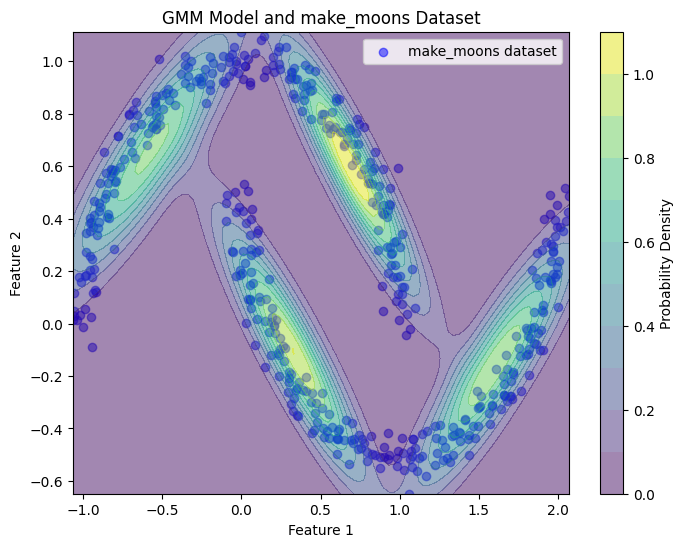

In [7]:
# import numpy as np
# from sklearn.datasets import make_moons
# import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
# from typing import Dict

# Define your Gaussian function for multivariate data
def gaussian_multivar(x, mean, cov_mat):
    dimn = np.shape(x)[1]
    inv_cov = np.linalg.inv(cov_mat)
    x_minus_mu = x - mean
    arg_for_expn = 0.5 * np.sum(x_minus_mu @ inv_cov * x_minus_mu, axis=1)
    det_cov = np.linalg.det(cov_mat)
    prob = np.exp(-arg_for_expn) / (np.sqrt(det_cov) * ((2 * np.pi) ** (dimn / 2)))
    return prob

# Initialize GMM parameters
L = 4 # Number of components
dimn_of_prob = X.shape[1]

# Initial guess for GMM parameters
initial_means = np.random.rand(L, dimn_of_prob)
initial_covs = [np.eye(dimn_of_prob) for _ in range(L)]
initial_mixing_coeffs = np.random.rand(1, L)
initial_mixing_coeffs /= np.sum(initial_mixing_coeffs)  # Normalize

# Create a dictionary to store covariance matrices
covariance_matrices = {i: initial_covs[i] for i in range(L)}

# Train the GMM model using the EM algorithm
trained_means, trained_covs, trained_mixing_coeffs = EM_training(
    mean=initial_means,
    mixing_coeffs=initial_mixing_coeffs,
    covs=covariance_matrices,
    dataset_input=X,
    num_iters=100,
    tol=0.0001
)

print("trained means are:"); print(trained_means)
print("trained_covs are:");print(trained_covs)
print("trained_mixing_coeffs are:");print(trained_mixing_coeffs)

# Plot the original data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='blue', label='make_moons dataset', alpha=0.5)


# Plot the GMM model
###############################
x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
xy = np.column_stack([x.ravel(), y.ravel()])
pdf_values = np.zeros_like(x)
for idx in range(L):
    component_pdf = trained_mixing_coeffs[0, idx] * multivariate_normal.pdf(xy, trained_means[idx, :], trained_covs[idx])
    pdf_values += component_pdf.reshape(x.shape)

# Create a contour plot for the GMM model with a color bar
contour = plt.contourf(x, y, pdf_values, levels=10, cmap='viridis', alpha=0.5)
colorbar = plt.colorbar(contour, label='Probability Density')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('GMM Model and make_moons Dataset')
plt.show()
##################################


#### Not working from here
# pdf_values = np.zeros_like(x)
# for idx in range(L):
#     pdf_values += trained_mixing_coeffs[0, idx] * multivariate_normal.pdf(xy, trained_means[idx, :], trained_covs[idx])
# pdf_values = pdf_values.reshape(x.shape)  # Reshape to match the shape of pdf_values

# pdf_values = np.zeros_like(x)
# for idx in range(L):
#     component_pdf = trained_mixing_coeffs[0, idx] * multivariate_normal.pdf(xy, trained_means[idx, :], trained_covs[idx])
#     pdf_values += component_pdf
# pdf_values = pdf_values.reshape(x.shape)  # Reshape to match the shape of pdf_values
#### not working: till here



# Plot the GMM model
# x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
# xy = np.column_stack([x.ravel(), y.ravel()])
# pdf_values = np.zeros(xy.shape[0])
# for idx in range(L):
#     pdf_values += trained_mixing_coeffs[0, idx] * multivariate_normal.pdf(xy, trained_means[idx, :], trained_covs[idx])
# pdf_values = pdf_values.reshape(x.shape)  # Reshape to match the shape of pdf_values
# plt.contour(x, y, pdf_values, levels=10, colors='red', alpha=0.5, label='GMM Model')

# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend()
# plt.title('GMM Model and make_moons Dataset')
# plt.show()




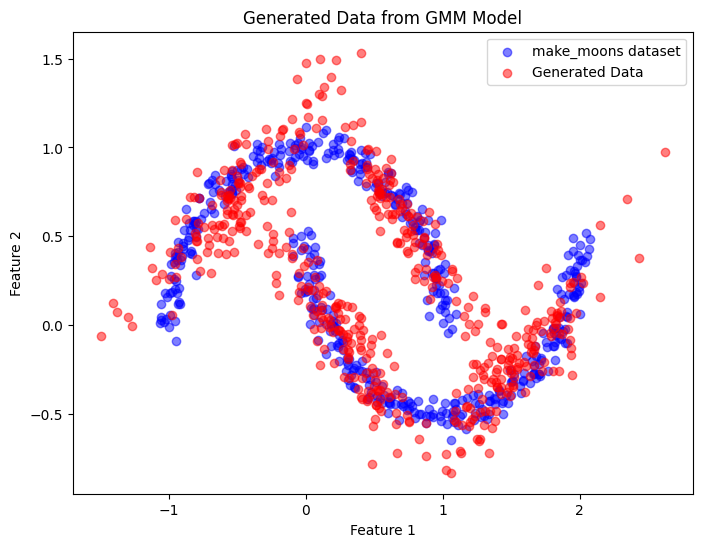

In [11]:
### Sampling from the GMM
from scipy.stats import multivariate_normal

def sample_from_gmm(num_samples, mixing_coeffs, mean_array, covs):

    samples = []
    for _ in range(num_samples):
        # Sample a component based on mixing coefficients
        component = np.random.choice(len(mixing_coeffs[0]), p=mixing_coeffs[0])

        # Sample from the selected component
        sample = np.random.multivariate_normal(mean_array[component, :], covs[component])
        samples.append(sample)

    return np.array(samples)

n_samples=n_samples_medium

# Using the estimated parameters from the GMM model
# mixing_coeffs = np.array([[0.4, 0.6]])  # Adjust with your mixing coefficients
# mean_array = np.array([[1.0, 1.0], [3.0, 3.0]])  # Adjust with your component means
# covs = [np.array([[0.1, 0.05], [0.05, 0.2]]), np.array([[0.2, 0.03], [0.03, 0.1]])]  # Adjust with your component covariance matrices
mean_array, covs, mixing_coeffs=trained_means, trained_covs, trained_mixing_coeffs

# Sample new data points
generated_samples = sample_from_gmm(n_samples_medium, mixing_coeffs, mean_array, covs)

# Plot the original data and the generated data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='blue', label='make_moons dataset', alpha=0.5)
plt.scatter(generated_samples[:, 0], generated_samples[:, 1], c='red', label='Generated Data', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Generated Data from GMM Model')
plt.show()


In [8]:
#### SK learn model for GMM
# import numpy as np
# from sklearn.datasets import make_moons
# import matplotlib.pyplot as plt
# from sklearn.mixture import GaussianMixture

# # Generate the 2D dataset using sklearn
# X, _ = make_moons(n_samples=100, noise=0.05, random_state=0)

# # Create and fit the Gaussian Mixture Model
# n_components = 2  # Number of components
# gmm = GaussianMixture(n_components=n_components, random_state=0)
# gmm.fit(X)

# # Visualize the data
# plt.figure(figsize=(8, 6))
# plt.scatter(X[:, 0], X[:, 1], c='blue', label='make_moons dataset', alpha=0.5)

# # Generate new data points using the GMM
# num_samples = 500
# generated_data_points = gmm.sample(num_samples)[0]

# plt.scatter(generated_data_points[:, 0], generated_data_points[:, 1], c='red', label='Generated data points', alpha=0.5)
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend()
# plt.title('GMM Model and make_moons Dataset')
# plt.show()


In [9]:
# I think this SK-learn's model is incorrect!
# import numpy as np
# from sklearn.datasets import make_moons
# import matplotlib.pyplot as plt
# from sklearn.mixture import GaussianMixture

# # Generate the 2D dataset using sklearn
# X, _ = make_moons(n_samples=500, noise=0.05, random_state=0)

# # Fit a Gaussian Mixture Model (GMM) to the data
# gmm = GaussianMixture(n_components=4)
# gmm.fit(X)

# # Create a meshgrid to visualize the GMM
# x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
# xy = np.column_stack([x.ravel(), y.ravel()])
# pdf_values = -gmm.score_samples(xy)
# pdf_values = pdf_values.reshape(x.shape)

# # Plot the original data
# plt.figure(figsize=(8, 6))
# plt.scatter(X[:, 0], X[:, 1], c='blue', label='make_moons dataset', alpha=0.5)

# # Create a contour plot for the GMM model with a color bar
# contour = plt.contourf(x, y, pdf_values, levels=10, cmap='viridis', alpha=0.5)
# colorbar = plt.colorbar(contour, label='Probability Density')

# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend()
# plt.title('GMM Model and make_moons Dataset')
# plt.show()


In [10]:
# import numpy as np
# from sklearn.datasets import make_moons
# import matplotlib.pyplot as plt
# from sklearn.mixture import GaussianMixture

# # Generate the 2D dataset using sklearn
# X, _ = make_moons(n_samples=100, noise=0.05, random_state=0)

# # Create and fit the Gaussian Mixture Model
# n_components = 2  # Number of components
# gmm = GaussianMixture(n_components=n_components, random_state=0)
# gmm.fit(X)

# # Visualize the data and the GMM model
# plt.figure(figsize=(8, 6))
# plt.scatter(X[:, 0], X[:, 1], c='blue', label='make_moons dataset', alpha=0.5)

# # Generate meshgrid for contour plot
# x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
# xy = np.column_stack([x.ravel(), y.ravel()])
# pdf_values = -gmm.score_samples(xy)  # Get log probability density

# # Reshape the log probability density values
# pdf_values = pdf_values.reshape(x.shape)

# # Create a contour plot for the GMM model
# plt.contour(x, y, pdf_values, levels=10, colors='red', alpha=0.5, label='GMM Model')

# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.legend()
# plt.title('GMM Model and make_moons Dataset')
# plt.show()


# Kernel density estimation.

Note that the kernel density estimation model is a non-parametric model, hence it does not require any "training" so to speak!


* discusses how to choose an appropriate bandwidth parameter: https://stats.libretexts.org/Bookshelves/Computing_and_Modeling/Supplemental_Modules_(Computing_and_Modeling)/Regression_Analysis/Nonparametric_Inference_-_Kernel_Density_Estimation#:~:text=Contributors-,Introduction%20and%20definition,%E2%88%88%CE%98%E2%8A%82Rd%7D.

1. Squared exponential kernel:
https://www.mathworks.com/help/stats/kernel-covariance-function-options.html

### defining kernel's required for the assingment.

1. Squared exponential kernel
2. Inverse-multi quadratic kernel

### 1. Squared exponential kernel:

In [13]:
# a=np.array([[1,2,3]]); b=np.array([[10,20,30]]) # just checking something
# norm(a-b)**2, a@a.T+b@b.T-2*a@b.T #they are the same, obviously! duh!

In [14]:
def squared_exp_kernel(xa:np.array, xb:np.array,bandwidth:float,amplitude:float=1):
  '''
  xa=row vector of shape (1xdimn_of_the_prob)
  xb= row vector of shape (1X dimn_of_the_prob)
  bandwidth: a hyperparameter
  amplitude: overall variance (set to 1 in the lecture, can be changed as well)
  '''
  diff=xa-xb
  kernel=(amplitude**2) *  np.exp( -np.dot(diff,diff)/(2*bandwidth) )
  return kernel

def inverse_multi_quadratic_kernel(xa:np.array, xb:np.array,bandwidth:float):
  '''
  xa=row vector of shape (1xdimn_of_the_prob)
  xb= row vector of shape (1X dimn_of_the_prob)
  bandwidth: a hyperparameter
  '''
  diff=xa-xb
  kernel=bandwidth/(bandwidth+ ((norm(diff))**2) )
  return kernel

def kernel_density_estimator(x:np.array, dataset:np.array, bandwidth:float, kernel_fn):
  '''
  x: a row vector (1X dimn of the problem) at which one wants to evaluate the KDE (prob function)
  dataset= an array of shape (N X dimn of the problem)
  bandwidth: hyperparameter
  kernel_fn: choice of the user
  '''
  num_data=np.shape(dataset)[0]
  list_kernel=[kernel_fn(xa=x,xb=dataset[j,:],bandwidth=bandwidth) for j in range(0,num_data)]
  prob=(1./num_data)*sum(list_kernel)## sometimes instead of 1./num_data , we also have 1./(bandwidth X num_data)
  return prob

Estimated bandwidth: 0.16249246279761534


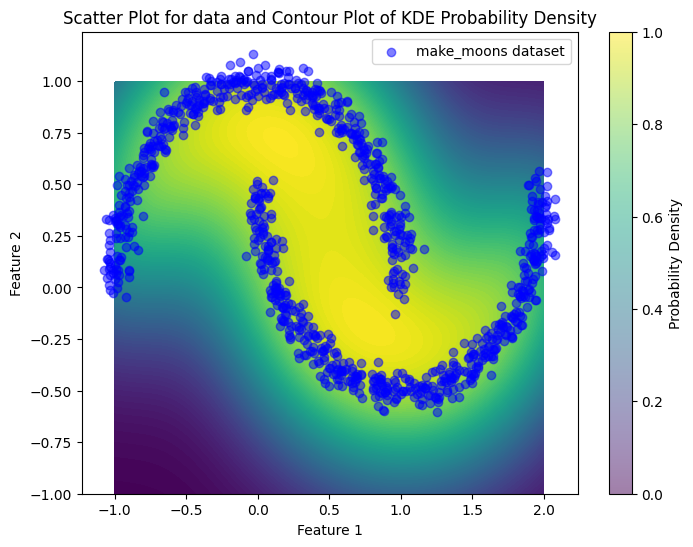

In [15]:
def estimate_bandwidth_with_silverman_rule(data):
    # Step 1: Calculate the standard deviation
    std_dev = np.std(data)

    # Step 2: Calculate the interquartile range (IQR)
    Q1 = np.percentile(data, 25, axis=0)
    Q3 = np.percentile(data, 75, axis=0)
    IQR = Q3 - Q1

    # Step 3: Estimate the bandwidth using Silverman's rule of thumb
    n = len(data)
    bandwidth = 0.9 * min(std_dev, np.mean(IQR) / 1.34) * n ** (-1 / 5)

    return bandwidth

# Example usage with your dataset
from sklearn.datasets import make_moons
X, _ = make_moons(n_samples=500, noise=0.05, random_state=0)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# Generate the make_moons dataset
X, _ = make_moons(n_samples=1000, noise=0.05, random_state=0)

# Define your squared exponential kernel function
def squared_exp_kernel(xa, xb, bandwidth):
    diff = xa - xb
    kernel = np.exp(-np.dot(diff, diff) / (2 * bandwidth))
    return kernel

# Define your KDE function
def kernel_density_estimator(x, dataset, bandwidth):
    num_data = dataset.shape[0]
    kernel_values = [squared_exp_kernel(x, dataset[i], bandwidth) for i in range(num_data)]
    prob = (1. / num_data) * sum(kernel_values)
    return prob

# Number of data points to generate
num_samples = 100

# Bandwidth parameter for the KDE
bandwidth =  estimate_bandwidth_with_silverman_rule(X)
print("Estimated bandwidth:", bandwidth) # Adjust the bandwidth as needed

# # Sample data points from the KDE model using acceptance-rejection method
# samples = []
# range for x and y axes
xmin, xmax = -1, 2  # Adjust the range as needed
ymin, ymax = -1, 1  # Adjust the range as needed

# # Create a grid of points within the specified range
x_grid = np.linspace(xmin, xmax, 100)
y_grid = np.linspace(ymin, ymax, 100)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid)
points = np.c_[X_grid.ravel(), Y_grid.ravel()]

# Evaluate the KDE at each point in the grid
kde_values = np.array([kernel_density_estimator(point, X, bandwidth) for point in points])
kde_values = kde_values.reshape(X_grid.shape)

# Create a contour plot
plt.figure(figsize=(8, 6))
plt.contourf(X_grid, Y_grid, kde_values, levels=100, cmap='viridis')
plt.scatter(X[:, 0], X[:, 1], c='blue', label='make_moons dataset', alpha=0.5)
plt.colorbar(label='Probability Density')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot for data and Contour Plot of KDE Probability Density')
plt.legend()
plt.show()

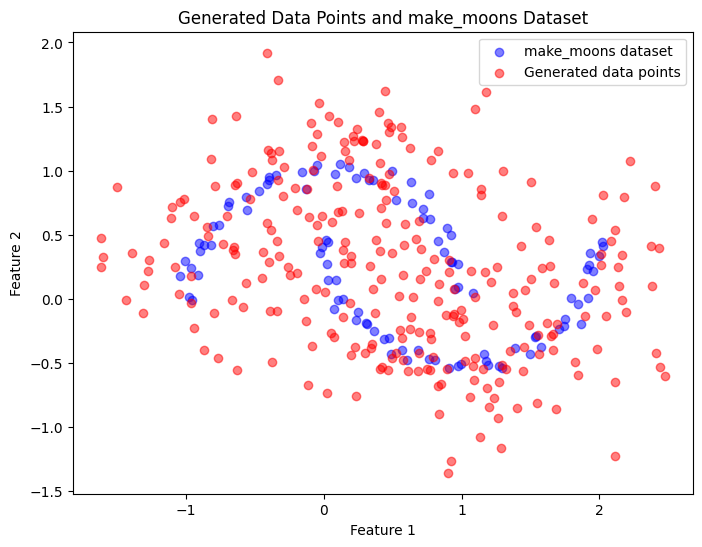

In [19]:
### I am facing some issue with the samppling. rest is all correct! i think so!!!
num_samples=10000
# Sample data points from the KDE model using acceptance-rejection method
samples = []
# range for x and y axes
xmin, xmax = -3, 3  # Adjust the range as needed
ymin, ymax = -3, 3  # Adjust the range as needed

# acceptance-rejection method to sample from the given probability distribution
for _ in range(num_samples):
    random_point = np.array([xmin + (xmax - xmin) * np.random.rand(), ymin + (ymax - ymin) * np.random.rand()])  # Generate random points in 2D space
    prob = kernel_density_estimator(random_point, X, bandwidth)  # Calculate the probability density
    if np.random.rand() < prob:  # Accept the point with probability equal to the density
        samples.append(random_point)

samples = np.array(samples)

# Visualize the original data and the generated data
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='blue', label='make_moons dataset', alpha=0.5)
plt.scatter(samples[:, 0], samples[:, 1], c='red', label='Generated data points', alpha=0.5)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.title('Generated Data Points and make_moons Dataset')
plt.legend()
plt.show()

## Implementation of MMD metric:

a good resource for MMD: https://www.onurtunali.com/ml/2019/03/08/maximum-mean-discrepancy-in-machine-learning.html

(implemented using pytorch)